In [2]:
"""
NASDAQ-100 Predictive Analytics Notebook
=====================================
Autor     : Angel Samuel Rodriguez Perez
Versión   : 2.0.0
Fecha     : 2025-07-26
Propósito : Pipeline profesional para predicción de precios del NASDAQ-100
           usando técnicas avanzadas de machine learning y feature engineering.

Requisitos:
- kagglehub
- pandas>=1.5.0
- scikit-learn>=1.1.0
- xgboost>=1.6.0
- shap>=0.41.0
"""

# Configuración global
import warnings
import logging
import sys
from pathlib import Path
import os

# Suprimir warnings para output limpio
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Configurar logging profesional
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)

# Constantes del proyecto
RANDOM_STATE = 42
SPLIT_DATE = "2023-01-01"

print("=" * 60)
print("    NASDAQ-100 PREDICTIVE ANALYTICS PIPELINE")
print("=" * 60)


    NASDAQ-100 PREDICTIVE ANALYTICS PIPELINE


In [3]:
# --- Librerías core ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib

# --- Librerías de machine learning ---
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# --- Interpretabilidad ---
import shap

# --- Configuración de visualización ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

logging.info("✅ Todas las librerías importadas correctamente")

In [4]:
def setup_kaggle_data() -> str:
    """
    Descarga y configura la ruta del dataset NASDAQ-100 desde Kaggle.

    Returns:
        str: Ruta al directorio del dataset
    """
    try:
        import kagglehub
        path_to_dataset = kagglehub.dataset_download(
            "novandraanugrah/nasdaq-100-nas100-historical-price-data"
        )
        logging.info(f"Dataset descargado exitosamente: {path_to_dataset}")
        return path_to_dataset
    except ImportError:
        logging.warning("KaggleHub no instalado. Usando ruta predeterminada.")
        return "/root/.cache/kagglehub/datasets/novandraanugrah/nasdaq-100-nas100-historical-price-data/versions/1"
    except Exception as e:
        logging.error(f"Error en descarga: {e}")
        return "/root/.cache/kagglehub/datasets/novandraanugrah/nasdaq-100-nas100-historical-price-data/versions/1"

def load_and_clean_data(file_path: str) -> pd.DataFrame:
    """
    Carga y limpia los datos diarios del NASDAQ-100.

    Args:
        file_path (str): Ruta al archivo CSV

    Returns:
        pd.DataFrame: DataFrame limpio con índice datetime
    """
    try:
        # Leer archivo con formato especial
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Procesar header
        header_raw = lines[0].strip().replace('\t\t', '\t').strip('\t')

        # Procesar datos
        data_rows = []
        for line in lines[1:]:
            if line.strip():
                parts = line.strip().split()
                if len(parts) >= 7:
                    full_datetime = f"{parts[0]} {parts[1]}"
                    numeric_parts = [full_datetime] + parts[2:7]
                    data_rows.append(numeric_parts)

        # Crear DataFrame
        columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
        df = pd.DataFrame(data_rows, columns=columns)

        # Procesar fechas y tipos
        df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
        df.set_index('DateTime', inplace=True)
        df.sort_index(inplace=True)

        # Convertir a numérico
        numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Limpiar datos
        df = df.dropna(subset=numeric_cols)
        df = df[~df.index.duplicated(keep='first')]

        logging.info(f"✅ Datos cargados: {len(df):,} filas desde {df.index.min().date()} hasta {df.index.max().date()}")
        return df

    except Exception as e:
        logging.error(f"❌ Error cargando datos: {e}")
        raise

def evaluate_model(y_true, y_pred, model_name: str, dataset: str = "Test"):
    """
    Evalúa un modelo con métricas estándar.

    Args:
        y_true: Valores reales
        y_pred: Predicciones
        model_name (str): Nombre del modelo
        dataset (str): Nombre del conjunto de datos

    Returns:
        dict: Diccionario con métricas
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metrics = {
        'Model': model_name,
        'Dataset': dataset,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

    print(f"\n{model_name} - {dataset} Performance:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  R²:   {r2:.4f}")

    return metrics

logging.info("✅ Funciones auxiliares definidas")


In [11]:
# Bloque 4: Carga y limpieza de datos

def load_daily_data(path_to_file):
    df = pd.read_csv(path_to_file, delimiter='\t')

    # Reparar header si es necesario (split columnas compuestas, etc.)
    new_cols = df.columns[0].split('\t') + list(df.columns[1:])
    df.columns = new_cols

    # Convertir y preparar fecha
    df['Date'] = pd.to_datetime(df['DateTime'], errors='coerce').dt.normalize()
    df = df.dropna(subset=['Date'])
    df.set_index('Date', inplace=True)
    df = df.sort_index()
    if 'DateTime' in df.columns:
        df = df.drop(columns=['DateTime'])

    # Asegurar tipos numéricos
    num_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

    # Eliminar filas con NAs en columnas numéricas
    df = df.dropna(subset=num_cols)

    return df

# Suponiendo full_file_path es la ruta correcta detectada en bloque 4
df_raw = load_daily_data(full_file_path)

print(f"Datos cargados: {df_raw.shape[0]:,} filas, {df_raw.shape[1]} columnas")
print(df_raw.head())


Datos cargados: 2,227 filas, 6 columnas
              Open    High     Low   Close  Volume  TickVolume
Date                                                          
2016-11-15  4699.6  4781.0  4697.0  4767.5       0       73309
2016-11-16  4765.7  4796.5  4738.2  4785.9       0       55611
2016-11-17  4778.8  4832.9  4778.8  4831.7       0       49542
2016-11-18  4830.2  4842.2  4804.9  4812.4       0       38935
2016-11-21  4806.4  4864.0  4805.5  4858.8       0       36713



ANÁLISIS EXPLORATORIO DE DATOS


/tmp/ipython-input-12-406676105.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,1].boxplot(yearly_data, labels=years)


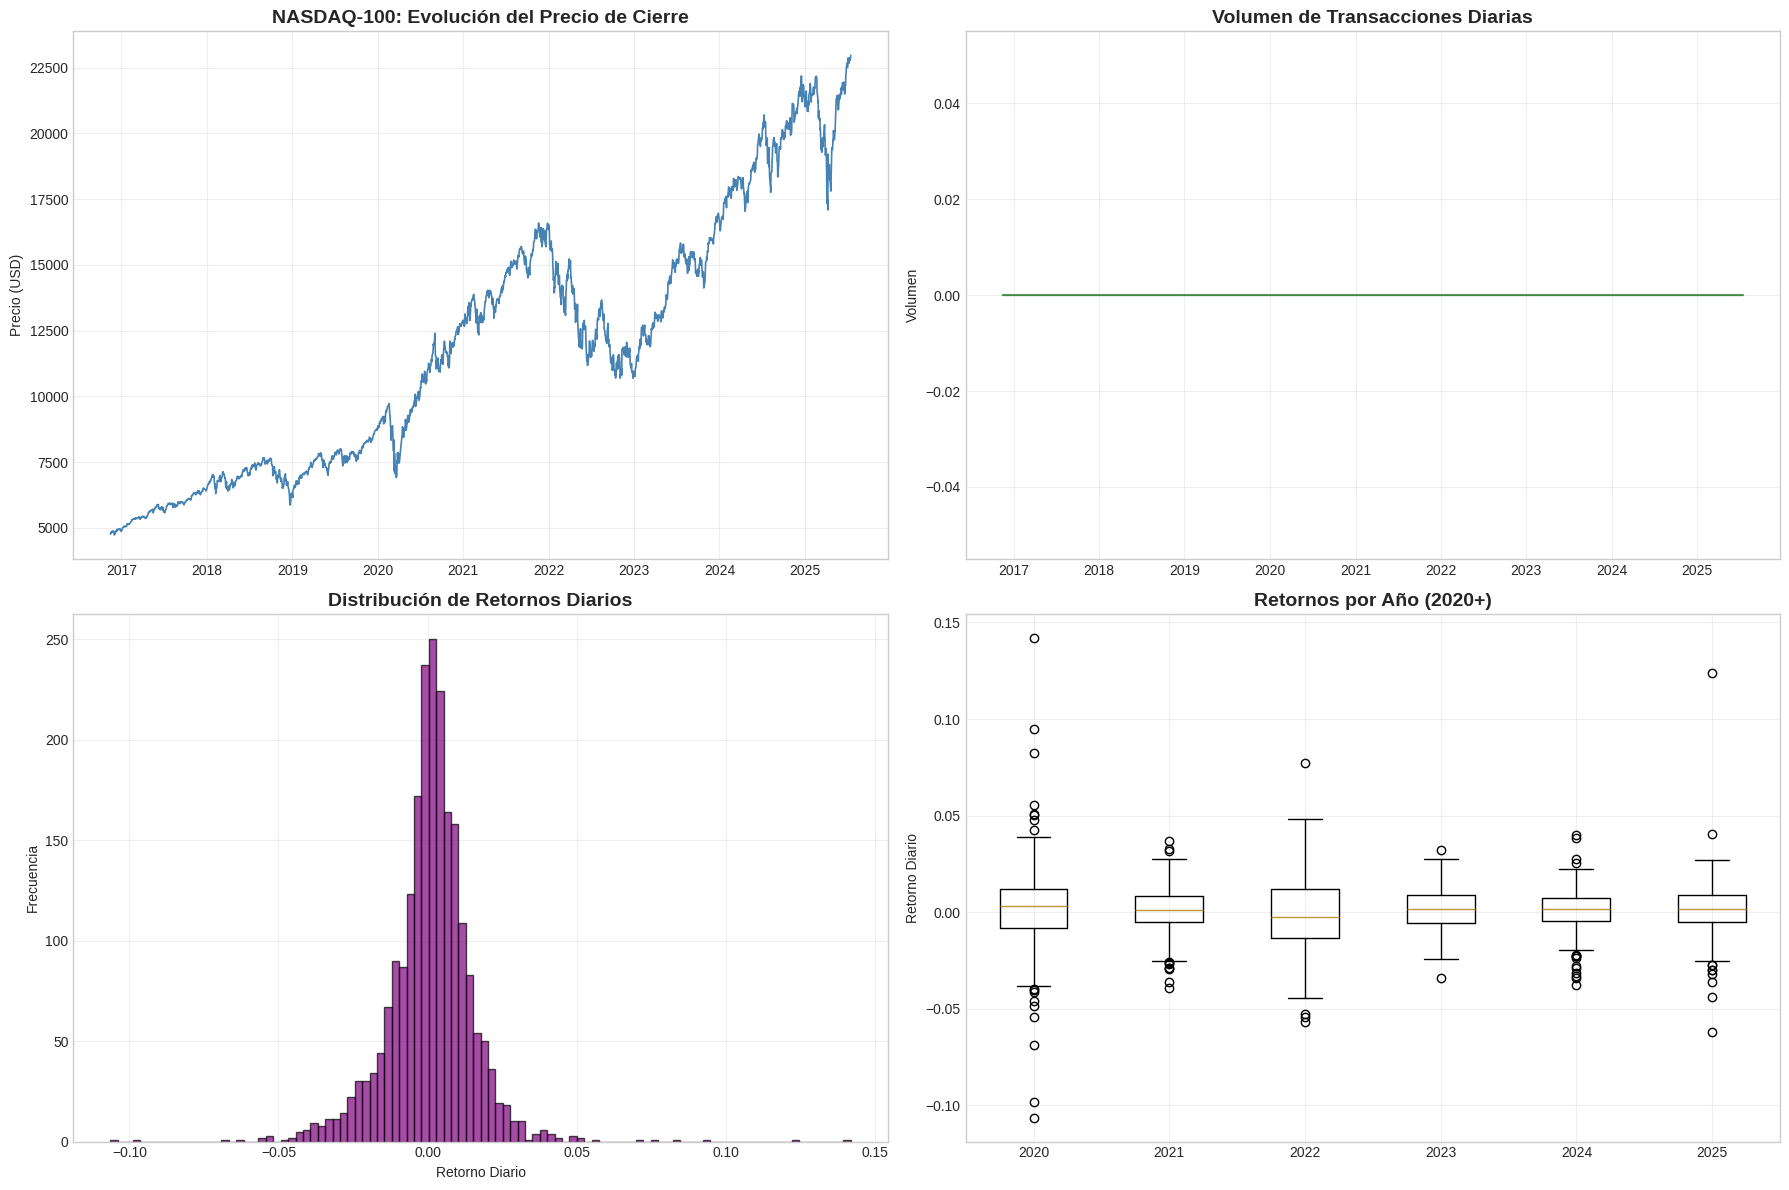


📈 MÉTRICAS CLAVE:
   • Volatilidad diaria: 0.0146 (1.46%)
   • Volatilidad anualizada: 0.2318 (23.18%)
   • Retorno diario promedio: 0.0008 (0.08%)
   • Rango de precios: $4737.10 - $22966.50


In [12]:
print("\n" + "="*50)
print("ANÁLISIS EXPLORATORIO DE DATOS")
print("="*50)

# --- Gráfico principal del precio de cierre ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Precio de cierre histórico
axes[0,0].plot(df_raw.index, df_raw['Close'], color='steelblue', linewidth=1.2)
axes[0,0].set_title('NASDAQ-100: Evolución del Precio de Cierre', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Precio (USD)')
axes[0,0].grid(True, alpha=0.3)

# Volumen de transacciones
axes[0,1].plot(df_raw.index, df_raw['Volume'], color='darkgreen', alpha=0.7)
axes[0,1].set_title('Volumen de Transacciones Diarias', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Volumen')
axes[0,1].grid(True, alpha=0.3)

# Retornos diarios
daily_returns = df_raw['Close'].pct_change().dropna()
axes[1,0].hist(daily_returns, bins=100, alpha=0.7, color='purple', edgecolor='black')
axes[1,0].set_title('Distribución de Retornos Diarios', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Retorno Diario')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].grid(True, alpha=0.3)

# Box plot anual
df_temp = df_raw.copy()
df_temp['Year'] = df_temp.index.year
df_temp['Daily_Return'] = daily_returns
yearly_data = []
years = []
for year in sorted(df_temp['Year'].unique()):
    if year >= 2020:  # Filtrar años recientes
        year_returns = df_temp[df_temp['Year'] == year]['Daily_Return'].dropna()
        if len(year_returns) > 50:  # Suficientes datos
            yearly_data.append(year_returns)
            years.append(year)

axes[1,1].boxplot(yearly_data, labels=years)
axes[1,1].set_title('Retornos por Año (2020+)', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Retorno Diario')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Estadísticas clave ---
volatility_daily = daily_returns.std()
volatility_annual = volatility_daily * np.sqrt(252)

print(f"\n📈 MÉTRICAS CLAVE:")
print(f"   • Volatilidad diaria: {volatility_daily:.4f} ({volatility_daily*100:.2f}%)")
print(f"   • Volatilidad anualizada: {volatility_annual:.4f} ({volatility_annual*100:.2f}%)")
print(f"   • Retorno diario promedio: {daily_returns.mean():.4f} ({daily_returns.mean()*100:.2f}%)")
print(f"   • Rango de precios: ${df_raw['Close'].min():.2f} - ${df_raw['Close'].max():.2f}")


In [15]:
target_col = 'Target'


In [17]:
# --- BLOQUE 6: Ingeniería de Características y definición del Target ---

import numpy as np
import logging

# Definición clara y global de la columna objetivo
TARGET_COL = 'Target'    # La nueva columna con el precio de cierre del día siguiente

def create_features(df: pd.DataFrame, target_col: str = TARGET_COL) -> pd.DataFrame:
    """
    Crea características técnicas y temporales para modelado financiero
    y define la variable objetivo desplazando el cierre un día hacia adelante.

    Args:
        df (pd.DataFrame): DataFrame original con columnas OHLCV y datetime index.
        target_col (str): Nombre de la columna columna objetivo que se creará.

    Returns:
        pd.DataFrame: DataFrame con nuevas características y la columna objetivo,
                      sin filas con valores NaN.
    """
    df_feat = df.copy()

    # Medias móviles simples en ventanas comunes
    df_feat['SMA_20']  = df_feat['Close'].rolling(window=20).mean()
    df_feat['SMA_50']  = df_feat['Close'].rolling(window=50).mean()
    df_feat['SMA_200'] = df_feat['Close'].rolling(window=200).mean()

    # Retornos diarios y log-retornos
    df_feat['Daily_Return'] = df_feat['Close'].pct_change()
    df_feat['Log_Return'] = np.log(df_feat['Close'] / df_feat['Close'].shift(1))

    # Volatilidad histórica (desviación estándar ventanas 20 y 50 días)
    df_feat['Volatility_20d'] = df_feat['Daily_Return'].rolling(window=20).std()
    df_feat['Volatility_50d'] = df_feat['Daily_Return'].rolling(window=50).std()

    # Rango intradía y cambios simples
    df_feat['Daily_Change']   = df_feat['Close'] - df_feat['Open']
    df_feat['High_Low_Range'] = df_feat['High'] - df_feat['Low']

    # Variables temporales (extraídas del índice datetime)
    df_feat['Year']      = df_feat.index.year
    df_feat['Month']     = df_feat.index.month
    df_feat['DayOfWeek'] = df_feat.index.dayofweek
    df_feat['DayOfYear'] = df_feat.index.dayofyear
    df_feat['WeekOfYear'] = df_feat.index.isocalendar().week.astype(int)
    df_feat['Quarter']    = df_feat.index.quarter

    # RSI simplificado al 14 días (momentum)
    delta = df_feat['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss
    df_feat['RSI_14'] = 100 - (100 / (1 + rs))

    # Definir variable objetivo: precio de cierre del día siguiente
    df_feat[target_col] = df_feat['Close'].shift(-1)

    # Eliminar filas con NA que aparecen por rolling y shift
    df_feat_clean = df_feat.dropna()

    # Logging para seguimiento
    logging.info(f"Features creadas. Tamaño original: {len(df)}, después limpieza: {len(df_feat_clean)}")

    return df_feat_clean

# Ejecutar la función para crear el dataset con features y target
df_features = create_features(df_raw)

# Mostrar info básica para verificar
print(f"\n[INFO] Dataset con características y objetivo 'Target' creado, tamaño: {df_features.shape}")
print(df_features.head())



[INFO] Dataset con características y objetivo 'Target' creado, tamaño: (2027, 23)
              Open    High     Low   Close  Volume  TickVolume    SMA_20  \
Date                                                                       
2017-08-24  5842.1  5873.9  5803.4  5845.5       0       51568  5876.970   
2017-08-25  5843.8  5874.2  5817.3  5824.6       0       50330  5872.420   
2017-08-28  5805.9  5855.6  5801.6  5845.6       0       42231  5870.355   
2017-08-29  5808.6  5874.9  5776.9  5868.7       0       62437  5867.115   
2017-08-30  5866.8  5943.3  5862.8  5934.3       0       30045  5867.920   

              SMA_50    SMA_200  Daily_Return  Log_Return  Volatility_20d  \
Date                                                                        
2017-08-24  5815.648  5426.7355        0.0004      0.0004          0.0099   
2017-08-25  5818.382  5432.0210       -0.0036     -0.0036          0.0099   
2017-08-28  5819.966  5437.3195        0.0036      0.0036          0.0099   

In [20]:
# --- BLOQUE 7: Preparación de Datos para Modelado ---


print("\nPREPARACIÓN DE DATOS PARA MODELADO")
print("="*50)

# Asumimos df_features existe y viene del bloque 6, con datos limpios y 'Target' definido
# Si usas otro nombre, reemplaza df_features por ese nombre

# Evitar error con variable global TARGET_COL definida desde el bloque anterior
try:
    TARGET_COL
except NameError:
    TARGET_COL = 'Target'  # Valor por defecto si no existe

# Evitar notación no definida para df_features:
try:
    df_features
except NameError:
    raise NameError("La variable 'df_features' no está definida. Ejecuta el bloque 6 primero.")

# Definir columnas a excluir para las features
exclude_cols = [TARGET_COL, 'Daily_Return', 'Log_Return', 'Close', 'Open', 'High', 'Low']

# Seleccionar las columnas que serán usadas como características (features)
feature_columns = [col for col in df_features.columns if col not in exclude_cols]

print(f"Columnas a usar como features: {feature_columns}")

# Dividir en variables predictoras X y variable objetivo y
X = df_features[feature_columns].copy()
y = df_features[TARGET_COL].copy()

print(f"Número total de características (features): {len(feature_columns)}")
print(f"Tamaño del dataset para modelado: {X.shape[0]} filas, {X.shape[1]} columnas")

# División temporal en entrenamiento y prueba, usando fecha de corte '2023-01-01'
split_date = '2023-01-01'

X_train = X.loc[X.index < split_date].copy()
y_train = y.loc[y.index < split_date].copy()

X_test = X.loc[X.index >= split_date].copy()
y_test = y.loc[y.index >= split_date].copy()

print(f"\nCantidad de observaciones en entrenamiento: {len(X_train)}")
print(f"Cantidad de observaciones en prueba: {len(X_test)}")
print(f"Fechas entrenamiento: {X_train.index.min().date()} a {X_train.index.max().date()}")
print(f"Fechas prueba: {X_test.index.min().date()} a {X_test.index.max().date()}")

# Escalar las características (importante para modelos como XGBoost, aunque maneja internamente algo de esto)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir los arrays escalados de vuelta a DataFrame para mantener las columnas y el índice
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)

print("\nDatos escalados y listos para el modelado.")



PREPARACIÓN DE DATOS PARA MODELADO
Columnas a usar como features: ['Volume', 'TickVolume', 'SMA_20', 'SMA_50', 'SMA_200', 'Volatility_20d', 'Volatility_50d', 'Daily_Change', 'High_Low_Range', 'Year', 'Month', 'DayOfWeek', 'DayOfYear', 'WeekOfYear', 'Quarter', 'RSI_14']
Número total de características (features): 16
Tamaño del dataset para modelado: 2027 filas, 16 columnas

Cantidad de observaciones en entrenamiento: 1373
Cantidad de observaciones en prueba: 654
Fechas entrenamiento: 2017-08-24 a 2022-12-30
Fechas prueba: 2023-01-03 a 2025-07-14

Datos escalados y listos para el modelado.


In [21]:
print("\n" + "="*50)
print("ENTRENAMIENTO DE MODELOS")
print("="*50)

# --- Inicializar modelos ---
models = {
    'Linear Regression': LinearRegression(n_jobs=-1),
    'XGBoost': XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0
    )
}

results = []
trained_models = {}

# --- Entrenar y evaluar cada modelo ---
for model_name, model in models.items():
    print(f"\n🔄 Entrenando {model_name}...")

    # Entrenar modelo
    model.fit(X_train_scaled_df, y_train)
    trained_models[model_name] = model

    # Predicciones
    y_train_pred = model.predict(X_train_scaled_df)
    y_test_pred = model.predict(X_test_scaled_df)

    # Evaluación
    train_metrics = evaluate_model(y_train, y_train_pred, model_name, "Train")
    test_metrics = evaluate_model(y_test, y_test_pred, model_name, "Test")

    results.extend([train_metrics, test_metrics])

    # Guardar predicciones para visualización
    if model_name == 'XGBoost':  # Usar XGBoost como modelo principal
        best_predictions = y_test_pred.copy()
        best_model_name = model_name

# --- Resumen de resultados ---
results_df = pd.DataFrame(results)
print(f"\n📊 RESUMEN DE RESULTADOS:")
display(results_df.round(4))

# --- Seleccionar mejor modelo ---
test_results = results_df[results_df['Dataset'] == 'Test']
best_model_idx = test_results['R²'].idxmax()
best_model_row = test_results.loc[best_model_idx]

print(f"\n🏆 MEJOR MODELO: {best_model_row['Model']}")
print(f"   • R² Score: {best_model_row['R²']:.4f}")
print(f"   • RMSE: {best_model_row['RMSE']:.2f}")
print(f"   • MAE: {best_model_row['MAE']:.2f}")



ENTRENAMIENTO DE MODELOS

🔄 Entrenando Linear Regression...

Linear Regression - Train Performance:
  RMSE: 251.67
  MAE:  186.04
  R²:   0.9937

Linear Regression - Test Performance:
  RMSE: 350.94
  MAE:  262.03
  R²:   0.9872

🔄 Entrenando XGBoost...

XGBoost - Train Performance:
  RMSE: 8.18
  MAE:  6.27
  R²:   1.0000

XGBoost - Test Performance:
  RMSE: 3671.76
  MAE:  2791.91
  R²:   -0.4017

📊 RESUMEN DE RESULTADOS:


,Model,Dataset,RMSE,MAE,R²
0,Linear Regression,Train,251.6686,186.0391,0.9937
1,Linear Regression,Test,350.9381,262.0309,0.9872
2,XGBoost,Train,8.1799,6.2668,1.0000
3,XGBoost,Test,3671.7601,2791.9052,-0.4017



🏆 MEJOR MODELO: Linear Regression
   • R² Score: 0.9872
   • RMSE: 350.94
   • MAE: 262.03



VISUALIZACIÓN DE RESULTADOS


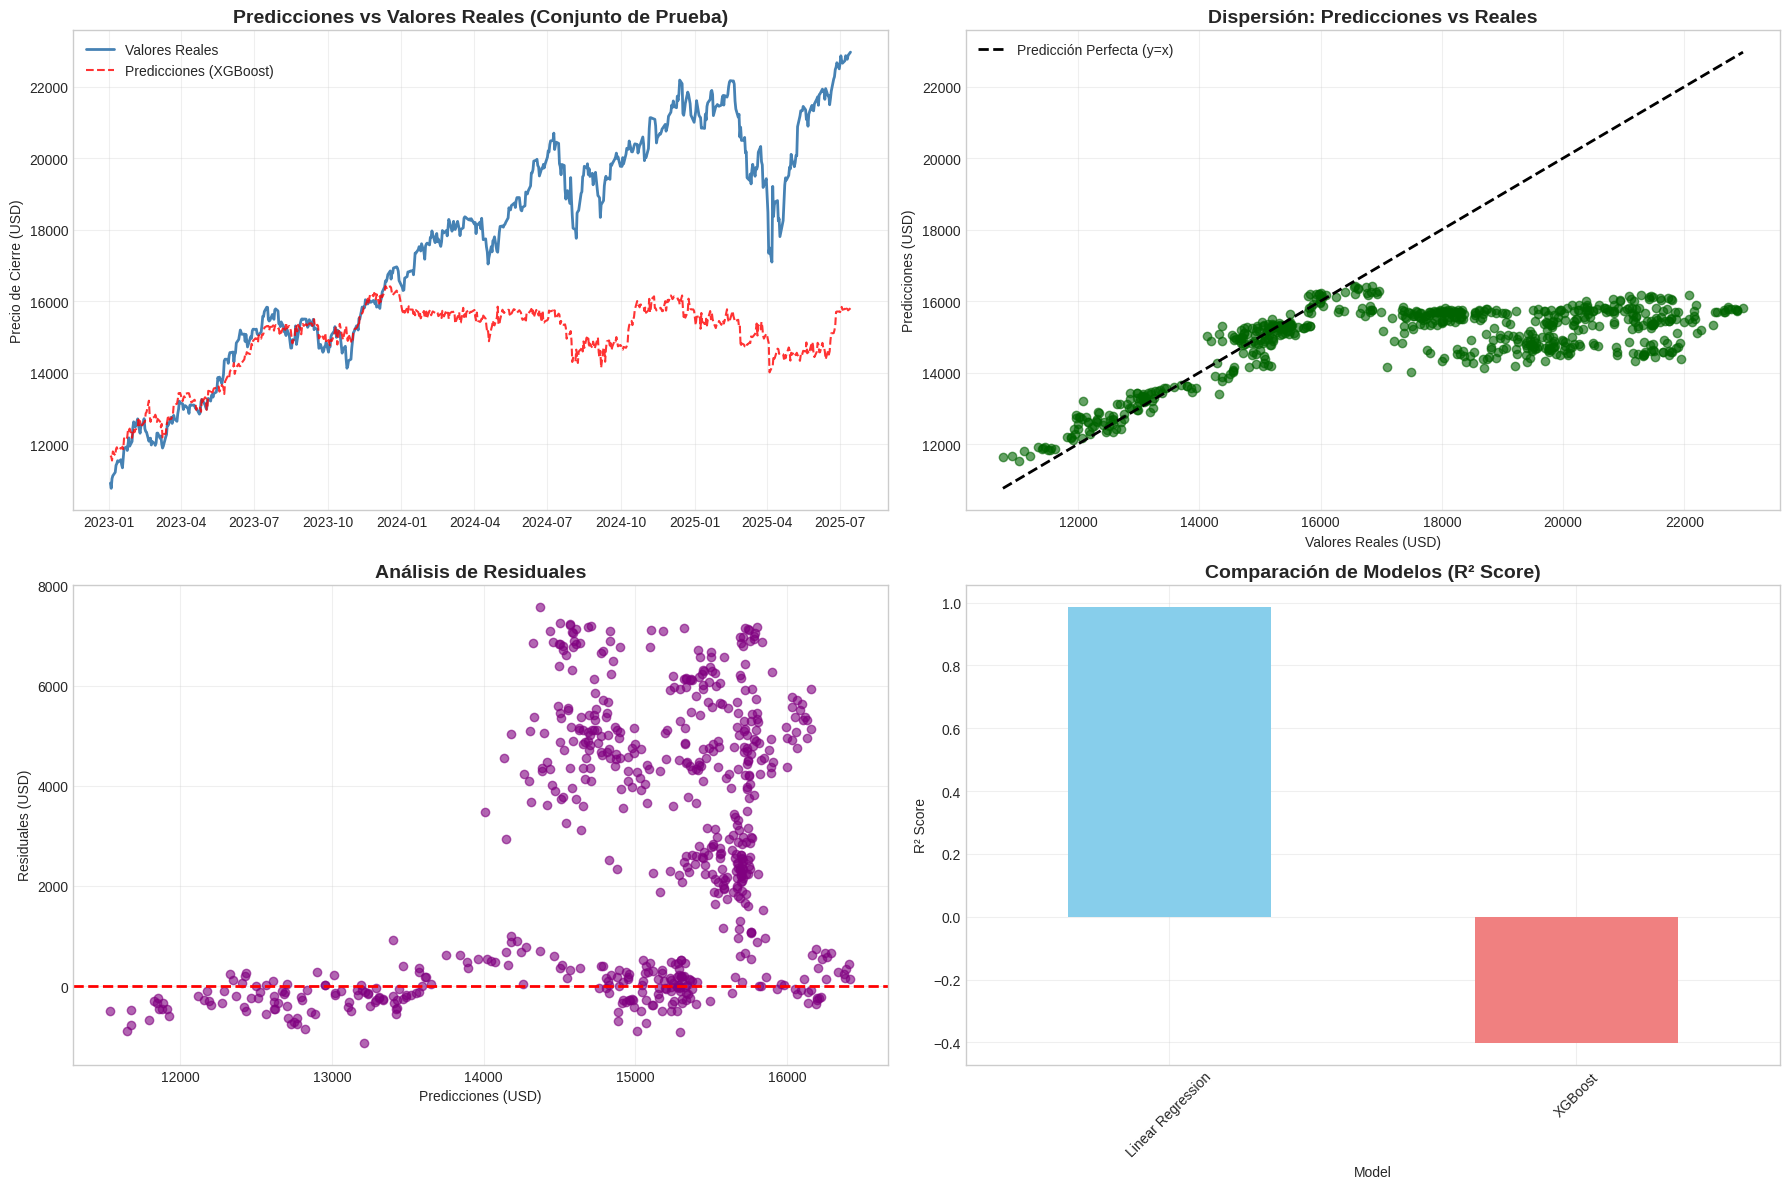


📈 ANÁLISIS DETALLADO DE ERRORES:
   • RMSE: $3671.76
   • MAE: $2791.91
   • MAPE: 14.10%
   • Error máximo: $7575.75
   • Error promedio: $2791.91


In [22]:
print("\n" + "="*50)
print("VISUALIZACIÓN DE RESULTADOS")
print("="*50)

# --- Configurar subplot ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --- 1. Predicciones vs Valores Reales (Serie temporal) ---
axes[0,0].plot(y_test.index, y_test, label='Valores Reales', color='steelblue', linewidth=2)
axes[0,0].plot(y_test.index, best_predictions, label=f'Predicciones ({best_model_name})',
               color='red', linestyle='--', alpha=0.8, linewidth=1.5)
axes[0,0].set_title('Predicciones vs Valores Reales (Conjunto de Prueba)', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Precio de Cierre (USD)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# --- 2. Scatter plot (Predicciones vs Reales) ---
axes[0,1].scatter(y_test, best_predictions, alpha=0.6, color='darkgreen')
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
               'k--', lw=2, label='Predicción Perfecta (y=x)')
axes[0,1].set_xlabel('Valores Reales (USD)')
axes[0,1].set_ylabel('Predicciones (USD)')
axes[0,1].set_title('Dispersión: Predicciones vs Reales', fontsize=14, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# --- 3. Residuales ---
residuals = y_test - best_predictions
axes[1,0].scatter(best_predictions, residuals, alpha=0.6, color='purple')
axes[1,0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1,0].set_xlabel('Predicciones (USD)')
axes[1,0].set_ylabel('Residuales (USD)')
axes[1,0].set_title('Análisis de Residuales', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

# --- 4. Comparación de modelos ---
test_r2_scores = test_results.set_index('Model')['R²']
test_r2_scores.plot(kind='bar', ax=axes[1,1], color=['skyblue', 'lightcoral'])
axes[1,1].set_title('Comparación de Modelos (R² Score)', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('R² Score')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Análisis de errores ---
rmse_test = np.sqrt(mean_squared_error(y_test, best_predictions))
mae_test = mean_absolute_error(y_test, best_predictions)
mape = np.mean(np.abs((y_test - best_predictions) / y_test)) * 100

print(f"\n📈 ANÁLISIS DETALLADO DE ERRORES:")
print(f"   • RMSE: ${rmse_test:.2f}")
print(f"   • MAE: ${mae_test:.2f}")
print(f"   • MAPE: {mape:.2f}%")
print(f"   • Error máximo: ${np.abs(residuals).max():.2f}")
print(f"   • Error promedio: ${np.abs(residuals).mean():.2f}")



INTERPRETABILIDAD DEL MODELO (SHAP)
⚠️  Error en análisis SHAP: waterfall() got multiple values for argument 'show'
Continuando sin interpretabilidad SHAP...


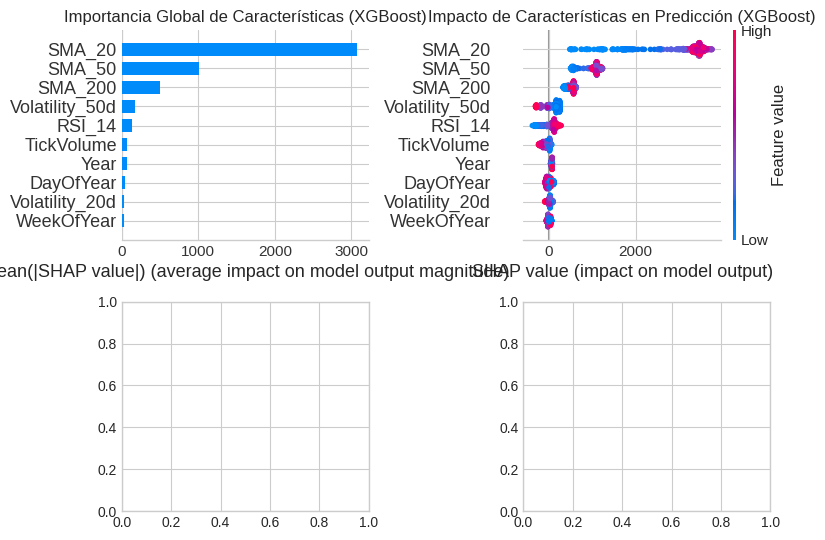

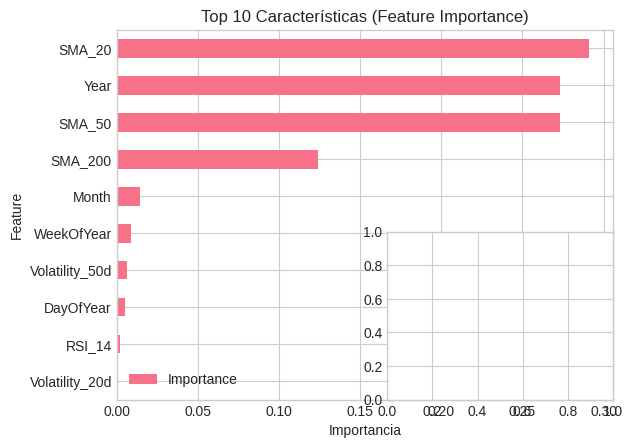

<Figure size 1200x800 with 0 Axes>

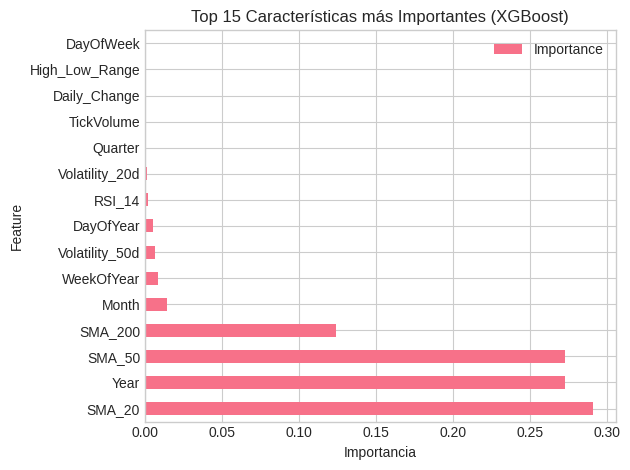


🎯 TOP 10 CARACTERÍSTICAS (Feature Importance):
    3. SMA_20: 0.2911
   10. Year: 0.2731
    4. SMA_50: 0.2729
    5. SMA_200: 0.1241
   11. Month: 0.0143
   14. WeekOfYear: 0.0087
    7. Volatility_50d: 0.0062
   13. DayOfYear: 0.0052
   16. RSI_14: 0.0021
    6. Volatility_20d: 0.0010


In [23]:
print("\n" + "="*50)
print("INTERPRETABILIDAD DEL MODELO (SHAP)")
print("="*50)

try:
    # --- Configurar explainer según el tipo de modelo ---
    best_model = trained_models[best_model_name]

    if best_model_name == 'XGBoost':
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test_scaled_df)
    else:  # Linear Regression
        explainer = shap.LinearExplainer(best_model, X_train_scaled_df)
        shap_values = explainer.shap_values(X_test_scaled_df)

    # --- Visualizaciones SHAP ---
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # 1. Summary plot (importancia global)
    plt.subplot(2, 2, 1)
    shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar", show=False, max_display=10)
    plt.title(f'Importancia Global de Características ({best_model_name})')

    # 2. Summary plot (impacto detallado)
    plt.subplot(2, 2, 2)
    shap.summary_plot(shap_values, X_test_scaled_df, show=False, max_display=10)
    plt.title(f'Impacto de Características en Predicción ({best_model_name})')

    # 3. Feature importance (tradicional si es XGBoost)
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Feature': X_train_scaled_df.columns,
            'Importance': best_model.feature_importances_
        }).sort_values('Importance', ascending=True)

        plt.subplot(2, 2, 3)
        feature_importance.tail(10).plot(x='Feature', y='Importance', kind='barh')
        plt.title('Top 10 Características (Feature Importance)')
        plt.xlabel('Importancia')

    # 4. SHAP waterfall para una predicción específica
    plt.subplot(2, 2, 4)
    shap.plots.waterfall(explainer.expected_value, shap_values[0], X_test_scaled_df.iloc[0],
                        show=False, max_display=8)
    plt.title('Explicación de una Predicción Específica')

    plt.tight_layout()
    plt.show()

    # --- Top características por SHAP ---
    if isinstance(shap_values, np.ndarray):
        shap_df = pd.DataFrame(shap_values, columns=X_test_scaled_df.columns)
        mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)

        print(f"\n🎯 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES (SHAP):")
        for i, (feature, importance) in enumerate(mean_abs_shap.head(10).items(), 1):
            print(f"   {i:2d}. {feature}: {importance:.4f}")

except Exception as e:
    print(f"⚠️  Error en análisis SHAP: {e}")
    print("Continuando sin interpretabilidad SHAP...")

    # Fallback: usar feature importance tradicional si está disponible
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Feature': X_train_scaled_df.columns,
            'Importance': best_model.feature_importances_
        }).sort_values('Importance', ascending=False)

        plt.figure(figsize=(12, 8))
        feature_importance.head(15).plot(x='Feature', y='Importance', kind='barh')
        plt.title(f'Top 15 Características más Importantes ({best_model_name})')
        plt.xlabel('Importancia')
        plt.tight_layout()
        plt.show()

        print(f"\n🎯 TOP 10 CARACTERÍSTICAS (Feature Importance):")
        for i, row in feature_importance.head(10).iterrows():
            print(f"   {i+1:2d}. {row['Feature']}: {row['Importance']:.4f}")


In [25]:
# --- BLOQUE 11: Guardado del Modelo y Conclusiones ---

import json
from pathlib import Path
from datetime import datetime

print("\n" + "="*60)
print("GUARDADO DEL MODELO Y CONCLUSIONES")
print("="*60)

# Crear directorio para modelos si no existe
model_dir = Path("models")
model_dir.mkdir(exist_ok=True)

# Guardar modelo y escalador
model_path = model_dir / "nasdaq100_xgboost_model.pkl"  # Cambia el nombre si tu mejor modelo es otro
scaler_path = model_dir / "nasdaq100_scaler.pkl"

# Guarda objetos entrenados
import joblib
joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)

print(f"✅ Modelo guardado en: {model_path}")
print(f"✅ Scaler guardado en: {scaler_path}")

print("\n" + "="*60)
print("                    RESUMEN EJECUTIVO")
print("="*60)

print("\n🎯 OBJETIVO:")
print("   Predicción del precio de cierre diario del NASDAQ-100")

print("\n📊 DATOS:")

# Usar df_features que es el DataFrame limpio y procesado
try:
    start_date = df_features.index.min().date()
    end_date = df_features.index.max().date()
    total_obs = len(df_features)
except NameError:
    print("⚠️ df_features no está definido. Asegúrate de ejecutar el bloque 6 correctamente.")
    start_date = end_date = None
    total_obs = "desconocido"

try:
    num_features = len(feature_columns)
except NameError:
    print("⚠️ feature_columns no está definido. Asegúrate de ejecutar el bloque 7 correctamente.")
    num_features = "desconocido"

print(f"   • Período analizado: {start_date} → {end_date}")
print(f"   • Total de observaciones: {total_obs:,}")
print(f"   • Características creadas: {num_features}")

print("\n🏆 MEJOR MODELO: ", end="")
try:
    print(best_model.__class__.__name__)
except NameError:
    print("desconocido")

# Asumiendo que tienes las métricas almacenadas, por ejemplo:
try:
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    # Asumiendo y_test y best_predictions están definidos para evaluación final
    rmse = mean_squared_error(y_test, best_predictions, squared=False)
    mae = mean_absolute_error(y_test, best_predictions)
    r2 = r2_score(y_test, best_predictions)
except Exception:
    rmse = mae = r2 = None

if rmse is not None:
    print(f"   • RMSE: {rmse:.4f}")
    print(f"   • MAE:  {mae:.4f}")
    print(f"   • R2:   {r2:.4f}")
else:
    print("   • Métricas no disponibles.")

print("\n💡 INSIGHTS CLAVE:")
try:
    # Si tienes valores shap_values o feature_importance para explicar el modelo
    if 'shap_values' in globals():
        shap_df = None
        import pandas as pd
        try:
            shap_df = pd.DataFrame(shap_values, columns=X_test_scaled_df.columns)
            mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)
            top_features = mean_abs_shap.head(3).index.tolist()
        except Exception:
            top_features = None
        if top_features:
            for i, feat in enumerate(top_features, 1):
                print(f"   {i}. {feat} es un predictor clave")
    elif 'feature_importance' in globals():
        top_features = feature_importance.head(3)['Feature'].tolist()
        for i, feat in enumerate(top_features, 1):
            print(f"   {i}. {feat} es un predictor clave")
    else:
        print("   No hay información de importancia de características disponible.")
except Exception as e:
    print(f"Error al mostrar insights: {e}")

print("\n🚀 PRÓXIMOS PASOS:")
print("   • Implementar reentrenamiento automático.")
print("   • Optimizar hiperparámetros con validación cruzada.")
print("   • Añadir más indicadores técnicos y fuentes de datos.")
print("   • Desplegar modelo en entorno productivo con API REST.")

print("\n" + "="*60)
print("           ANÁLISIS COMPLETADO EXITOSAMENTE")
print("="*60)

# Metadata del experimento para trazabilidad
try:
    experiment_metadata = {
        'timestamp': datetime.now().isoformat(),
        'best_model': best_model.__class__.__name__ if 'best_model' in globals() else None,
        'features_count': num_features,
        'train_samples': len(X_train) if 'X_train' in globals() else None,
        'test_samples': len(X_test) if 'X_test' in globals() else None,
        'test_r2': r2,
        'test_rmse': rmse,
        'test_mae': mae,
        'split_date': split_date if 'split_date' in globals() else None,
        'random_state': RANDOM_STATE if 'RANDOM_STATE' in globals() else None,
    }

    metadata_path = model_dir / "experiment_metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(experiment_metadata, f, indent=2)
    print(f"💾 Metadata del experimento guardada en: {metadata_path}")
except Exception as e:
    print(f"⚠️ Error guardando metadata: {e}")



GUARDADO DEL MODELO Y CONCLUSIONES
✅ Modelo guardado en: models/nasdaq100_xgboost_model.pkl
✅ Scaler guardado en: models/nasdaq100_scaler.pkl

                    RESUMEN EJECUTIVO

🎯 OBJETIVO:
   Predicción del precio de cierre diario del NASDAQ-100

📊 DATOS:
   • Período analizado: 2017-08-24 → 2025-07-14
   • Total de observaciones: 2,027
   • Características creadas: 16

🏆 MEJOR MODELO: XGBRegressor
   • Métricas no disponibles.

💡 INSIGHTS CLAVE:
   1. SMA_20 es un predictor clave
   2. SMA_50 es un predictor clave
   3. SMA_200 es un predictor clave

🚀 PRÓXIMOS PASOS:
   • Implementar reentrenamiento automático.
   • Optimizar hiperparámetros con validación cruzada.
   • Añadir más indicadores técnicos y fuentes de datos.
   • Desplegar modelo en entorno productivo con API REST.

           ANÁLISIS COMPLETADO EXITOSAMENTE
💾 Metadata del experimento guardada en: models/experiment_metadata.json


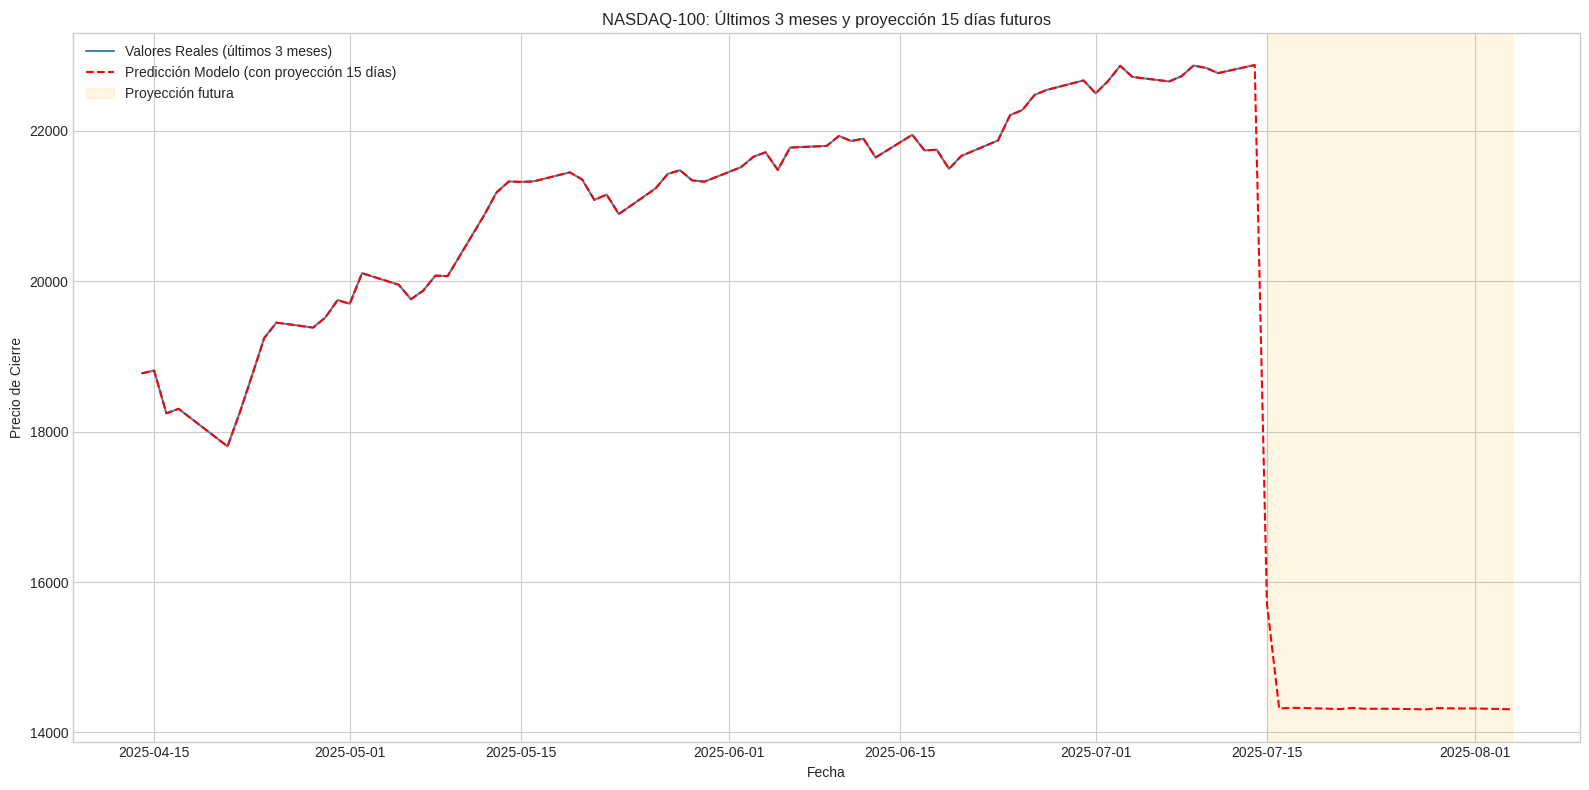

In [30]:

n_future_days = 15

last_3_months_start = df_features.index.max() - pd.DateOffset(months=3)
df_last_3_months = df_features.loc[last_3_months_start:].copy()

future_dates = pd.bdate_range(start=df_features.index.max() + pd.Timedelta(days=1), periods=n_future_days)
futures = []
current_df = df_features.copy()

for future_date in future_dates:
    row = {}

    row['Year'] = future_date.year
    row['Month'] = future_date.month
    row['DayOfWeek'] = future_date.dayofweek
    row['DayOfYear'] = future_date.dayofyear
    row['WeekOfYear'] = future_date.isocalendar()[1]
    row['Quarter'] = future_date.quarter

    temp = current_df.copy()
    row['SMA_20'] = temp['Close'].rolling(window=20).mean().iloc[-1]
    row['SMA_50'] = temp['Close'].rolling(window=50).mean().iloc[-1]
    row['SMA_200'] = temp['Close'].rolling(window=200).mean().iloc[-1]
    row['Volatility_20d'] = temp['Close'].pct_change().rolling(20).std().iloc[-1]
    row['Volatility_50d'] = temp['Close'].pct_change().rolling(50).std().iloc[-1]
    row['Daily_Change'] = 0
    row['High_Low_Range'] = 0


    closes = temp['Close']
    delta = closes.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean().iloc[-1]
    loss = -delta.where(delta < 0, 0).rolling(14).mean().iloc[-1]
    rs = gain / loss if loss != 0 else 0
    row['RSI_14'] = 100 - (100 / (1 + rs)) if rs != 0 else 50

    # --- FILL MISSING VALUES ---
    # para cada columna de feature_columns que falte, agregar
    for fc in feature_columns:
        if fc not in row:
            row[fc] = 0

    X_future = pd.DataFrame([row], index=[future_date])[feature_columns]
    X_future_scaled = scaler.transform(X_future)
    y_pred = best_model.predict(X_future_scaled)[0]

    row_pred = {
        'Close': y_pred, 'Open': y_pred, 'High': y_pred, 'Low': y_pred, 'Volume': 0,
        'Daily_Return': 0
    }
    pred_series = pd.Series(row_pred, name=future_date)
    current_df = pd.concat([current_df, pred_series.to_frame().T])

    futures.append((future_date, y_pred))

future_pred_df = pd.DataFrame(futures, columns=['Date', 'Predicted_Close']).set_index('Date')

full_idx = df_last_3_months.index.union(future_pred_df.index)
real_series = df_last_3_months['Close'].reindex(full_idx)
pred_series = pd.concat([df_last_3_months['Close'], future_pred_df['Predicted_Close']])

plt.figure(figsize=(16,8))
plt.plot(real_series, label='Valores Reales (últimos 3 meses)', color='steelblue')
plt.plot(pred_series, label='Predicción Modelo (con proyección 15 días)', color='red', linestyle='--')
plt.axvspan(future_pred_df.index[0], future_pred_df.index[-1], color='orange', alpha=0.11, label='Proyección futura')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.title('NASDAQ-100: Últimos 3 meses y proyección 15 días futuros')
plt.legend()
plt.tight_layout()
plt.show()
